# Initial Imports and Constants

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from lightkurve import search_targetpixelfile
import pandas as pd
import os
import batman
from scipy.stats import norm
import matplotlib
import os

In [2]:
### Define data directory
working_dir = os.getcwd()
data_dir = os.path.join(working_dir, "data")
print(f"Data directory: {data_dir}")

Data directory: /Users/pentrican10/Projects/tess-resonant-systems/data


In [3]:
### switch to mask out transits
mask_transits = True
### set range for search: [#hours] * [days per hour]
ttv_hour = 2* 0.0416667 # 1 hour to days

In [4]:
### function to convert times from TESS to Petigura offset
TESS_offset = 2457000
petigura_offset = 2454833
def convert_time_t2p(times):
    ### TESS offset 
    BTJD = times + TESS_offset
    new_time = BTJD - petigura_offset
    return new_time

# Get data

In [5]:
TOI_id = 'TOI 663'
search_result = lk.search_lightcurve(TOI_id, author='SPOC')
print(search_result)
# lc_collection = search_result.download_all()
# lc = lc_collection
# lc[0].download()
# lc[1].download()
# lc[2].download()
# lc[3].download()


# lc_collection = lc[0].download()
# lc_collection.append(lc[1].download())
# lc_collection.append(lc[3].download())

SearchResult containing 4 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 09 2019   SPOC     120    54962195      0.0
  1 TESS Sector 35 2021   SPOC     120    54962195      0.0
  2 TESS Sector 62 2023   SPOC     120    54962195      0.0
  3 TESS Sector 89 2025   SPOC     120    54962195      0.0


In [6]:
lc_collection = search_result.download_all()
# lc_collection.plot()
# plt.show()
print(lc_collection)

LightCurveCollection of 4 objects:
    0: <TessLightCurve LABEL="TIC 54962195" SECTOR=9 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 54962195" SECTOR=35 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    2: <TessLightCurve LABEL="TIC 54962195" SECTOR=62 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    3: <TessLightCurve LABEL="TIC 54962195" SECTOR=89 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>


In [7]:
clean_lcs = [lc[lc.quality == 0] for lc in lc_collection]


In [8]:
# Normalize, flatten, and remove outliers
processed_lcs = [
    lc.normalize().flatten(window_length=401).remove_outliers(sigma=5)
    for lc in clean_lcs
]

In [9]:
# Stitch into one combined light curve
combined_lc = processed_lcs[0]
for lc in processed_lcs[1:]:
    combined_lc = combined_lc.append(lc)



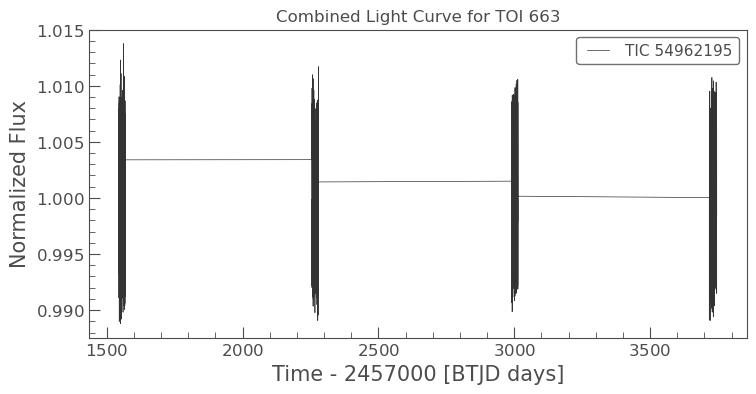

In [10]:
combined_lc.plot()
plt.title(f"Combined Light Curve for {TOI_id}")
plt.show()

In [11]:
# Extract useful data arrays
time = combined_lc.time.value
flux = combined_lc.flux.value
flux_err = combined_lc.flux_err.value
print(time)
print(flux)

[1545.05808932 1545.05947822 1545.06086712 ... 3745.45803327 3745.45942215
 3745.46081104]
[1.00374199 1.00065002 1.00360594 ... 0.99739315 1.00153122 0.99835169]


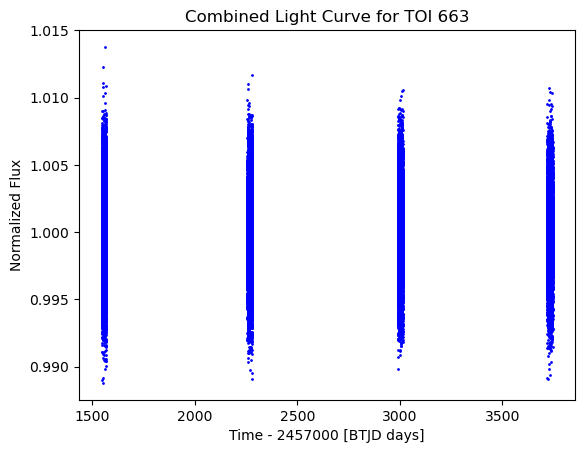

In [12]:
plt.scatter(time, flux, s=1, c='b')
plt.title(f'Combined Light Curve for {TOI_id}')
plt.xlabel('Time - 2457000 [BTJD days]')
plt.ylabel('Normalized Flux')
plt.show()

# BLS Runs

## BLS 1

`period` contains 174303 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


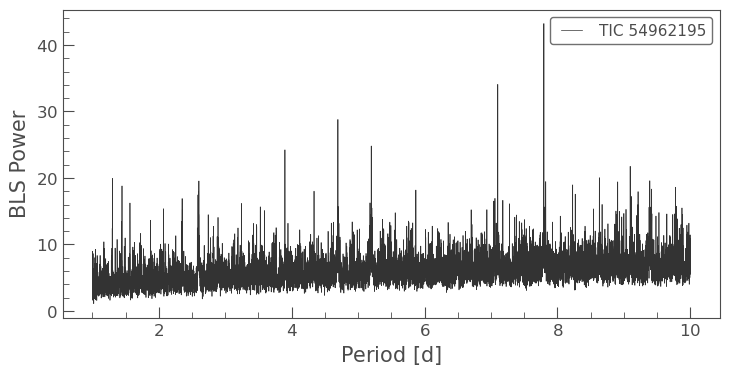

In [15]:
bls_1 = combined_lc.to_periodogram(method='bls', period=np.linspace(1, 10, 10000), frequency_factor=500)
bls_1.plot()
plt.show()


In [16]:
planet_1_period = bls_1.period_at_max_power
planet_1_dur = bls_1.duration_at_max_power
planet_1_t0 = bls_1.transit_time_at_max_power

print(f"Best candidate period: {planet_1_period.value:.5f} days")
print(f"Best candidate t0: {planet_1_t0.value:.5f} days")
print(f"Best candidate dur: {planet_1_dur.value:.5f} days")

Best candidate period: 7.79658 days
Best candidate t0: 1549.60809 days
Best candidate dur: 0.05000 days


In [17]:
import numpy as np
from scipy.signal import find_peaks

# 1. Access full power array
powers = bls_1.power.value
periods = bls_1.period.value
durations = bls_1.duration.value
t0s = bls_1.transit_time.value

# 2. Find all peaks in the BLS power spectrum
peaks, _ = find_peaks(powers)

# 3. Sort peaks by power (descending)
sorted_peaks = peaks[np.argsort(powers[peaks])[::-1]]

# 4. Get top 3 signal indices
top_indices = sorted_peaks[:7]

# 5. Extract their periods, durations, and t0s
top_periods = periods[top_indices]
top_durations = durations[top_indices]
top_t0s = t0s[top_indices]
top_powers = powers[top_indices]

# 6. Print results
for i in range(7):
    print(f"Signal {i+1}:")
    print(f"  Period:   {top_periods[i]:.5f} days")
    print(f"  T0:       {top_t0s[i]:.5f}")
    print(f"  Duration: {top_durations[i]:.5f} days")
    print(f"  Power:    {top_powers[i]:.5f}")
    print("-" * 30)


Signal 1:
  Period:   7.79658 days
  T0:       1549.60809
  Duration: 0.05000 days
  Power:    43.22452
------------------------------
Signal 2:
  Period:   7.10261 days
  T0:       1547.11309
  Duration: 0.05000 days
  Power:    34.07209
------------------------------
Signal 3:
  Period:   4.69577 days
  T0:       1548.06309
  Duration: 0.10000 days
  Power:    28.79357
------------------------------
Signal 4:
  Period:   5.19802 days
  T0:       1549.53809
  Duration: 0.10000 days
  Power:    24.80762
------------------------------
Signal 5:
  Period:   3.89829 days
  T0:       1547.00309
  Duration: 0.05000 days
  Power:    24.22453
------------------------------
Signal 6:
  Period:   9.09631 days
  T0:       1545.66809
  Duration: 0.05000 days
  Power:    21.74789
------------------------------
Signal 7:
  Period:   8.63186 days
  T0:       1549.61309
  Duration: 0.05000 days
  Power:    20.02904
------------------------------


In [18]:
# Create a cadence mask using the BLS parameters
planet_1_mask = bls_1.get_transit_mask(period=planet_1_period,
                                     transit_time=planet_1_t0,
                                     duration=planet_1_dur*1.5)

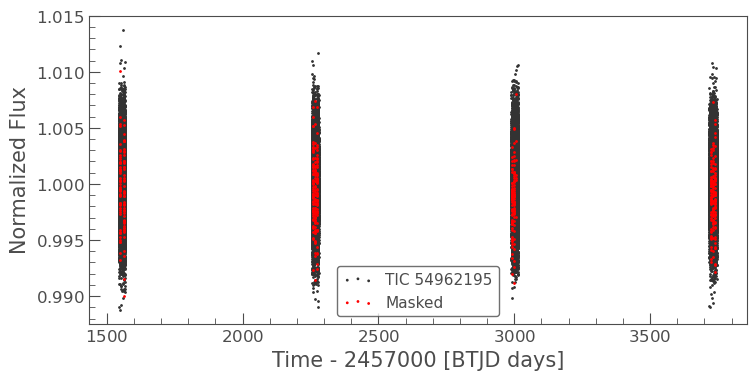

In [19]:
masked_lc_1 = combined_lc[~planet_1_mask]
ax = masked_lc_1.scatter();
combined_lc[planet_1_mask].scatter(ax=ax, c='r', label='Masked')
# plt.xlim(2144, 2145)
plt.show()

In [20]:
# Create a BLS model using the BLS parameters
planet_1_model = bls_1.get_transit_model(period=planet_1_period,
                                       transit_time=planet_1_t0,
                                       duration=planet_1_dur)


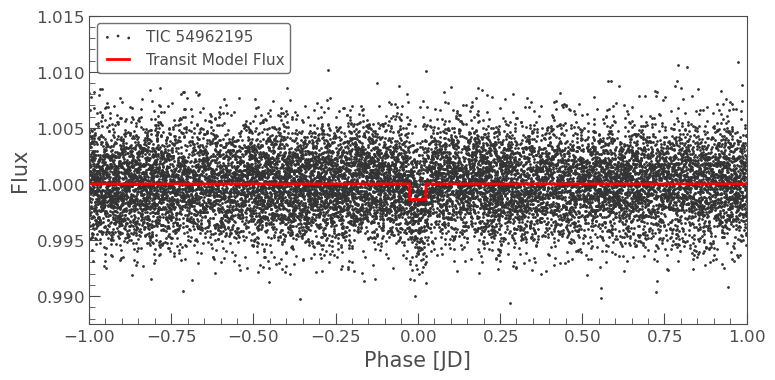

In [21]:
ax = combined_lc.fold(planet_1_period, planet_1_t0).scatter()
planet_1_model.fold(planet_1_period, planet_1_t0).plot(ax=ax, c='r', lw=2)
ax.set_xlim(-1, 1)
plt.show()

## BLS 2

`period` contains 161392 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


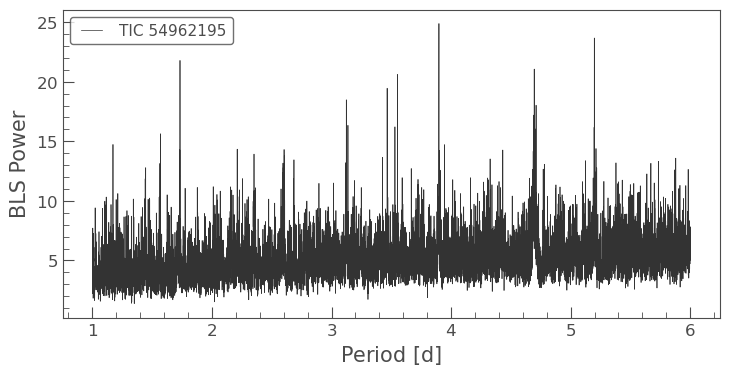

In [22]:
period = np.linspace(1, 6, 10000)
bls_2 = masked_lc_1.to_periodogram('bls', period=period, frequency_factor=500)
bls_2.plot()
plt.show()

In [23]:
planet_2_period = bls_2.period_at_max_power
planet_2_t0 = bls_2.transit_time_at_max_power
planet_2_dur = bls_2.duration_at_max_power

print(f"Best candidate period 2: {planet_2_period.value:.5f} days")
print(f"Best candidate t0 2: {planet_2_t0.value:.5f} days")

Best candidate period 2: 3.89829 days
Best candidate t0 2: 1547.00309 days


In [24]:
# ax = masked_lc_1.fold(planet_2_period, planet_2_t0).scatter()
# masked_lc_1.fold(planet_2_period, planet_2_t0).bin(.1).plot(ax=ax, c='r', lw=2,
#                                                           label='Binned Flux')
# ax.set_xlim(-5, 5)
# plt.show()

In [25]:
planet_2_mask = bls_2.get_transit_mask(period=planet_2_period,
                                     transit_time=planet_2_t0,
                                     duration=planet_2_dur*1.5)

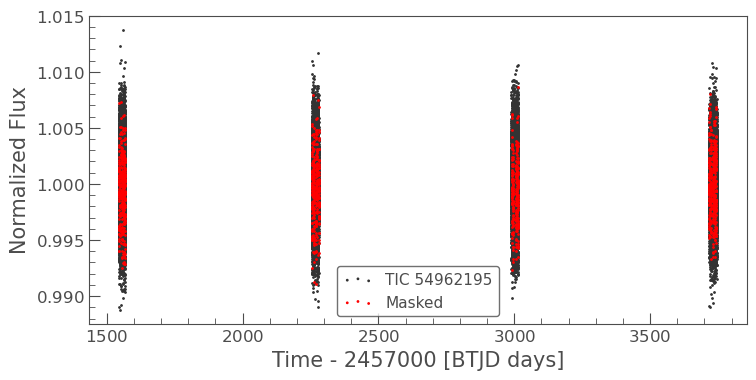

In [26]:
masked_lc_2 = masked_lc_1[~planet_2_mask]
ax = masked_lc_2.scatter();
masked_lc_1[planet_2_mask].scatter(ax=ax, c='r', label='Masked')
# plt.xlim(2144, 2145)
plt.show()

In [27]:
planet_2_model = bls_2.get_transit_model(period=planet_2_period,
                                       transit_time=planet_2_t0,
                                       duration=planet_2_dur)

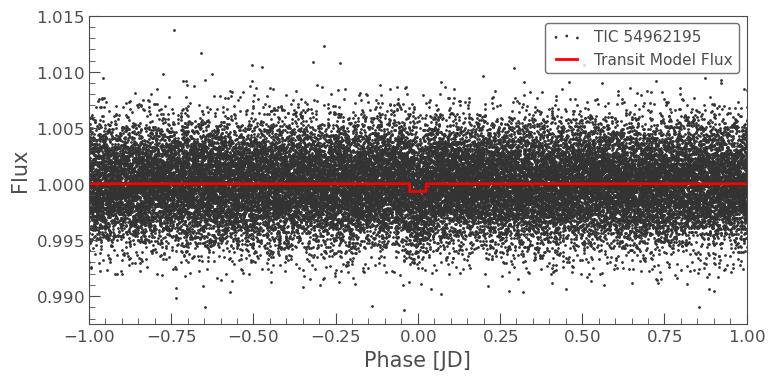

In [28]:
ax = combined_lc.fold(planet_2_period, planet_2_t0).scatter()
planet_2_model.fold(planet_2_period, planet_2_t0).plot(ax=ax, c='r', lw=2)
ax.set_xlim(-1, 1)
plt.show()

## Transit models

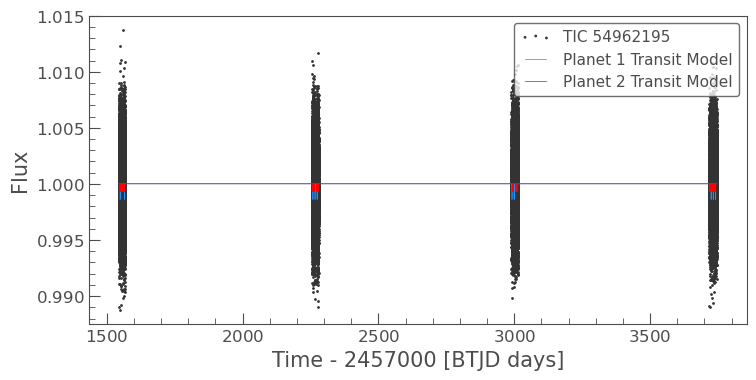

In [29]:
ax = combined_lc.scatter();
planet_1_model.plot(ax=ax, c='dodgerblue', label='Planet 1 Transit Model');
planet_2_model.plot(ax=ax, c='r', label='Planet 2 Transit Model');
# planet_3_model.plot(ax=ax, c='g', label='Planet 3 Transit Model');
# planet_4_model.plot(ax=ax, c='purple', label='Planet 4 Transit Model');
# planet_5_model.plot(ax=ax, c='orange', label='Planet 5? Transit Model');
# planet_6_model.plot(ax=ax, c='pink', label='Planet 6 Transit Model');

# plt.xlim(1340,1345)
# plt.ylim(0.998,1.002)
plt.show()

## Finding transit guess times based on models 

In [30]:
from scipy.signal import find_peaks

# Find all local minima (i.e., transit dips)
peaks_1, _ = find_peaks(-planet_1_model.flux.value, prominence=1e-5)
transit_times_1 = planet_1_model.time.value[peaks_1]
fluxes_1 = planet_1_model.flux.value[peaks_1]

print("Planet 1 transit dip times and depths:")
# for t, f in zip(transit_times_1, fluxes_1):
#     print(f"Time: {t:.5f}, Flux: {f:.6f}")
print(transit_times_1)

Planet 1 transit dip times and depths:
[1549.60672485 1565.20095924 2259.09635446 2266.89240581 2274.68974529
 2991.97526111 2999.77128877 3724.8536717  3732.6496694  3740.446935  ]


In [31]:
# Find all local minima (i.e., transit dips)
peaks_2, _ = find_peaks(-planet_2_model.flux.value, prominence=1e-5)
transit_times_2 = planet_2_model.time.value[peaks_2]
fluxes_2 = planet_2_model.flux.value[peaks_2]

print("Planet 2 transit dip times and depths:")
# for t, f in zip(transit_times_2, fluxes_2):
#     print(f"Time: {t:.5f}, Flux: {f:.6f}")
print(transit_times_2)

Planet 2 transit dip times and depths:
[1547.00254899 1550.90116861 1554.79836285 1558.6969178  1562.59546401
 1566.49397888 2256.49069935 2260.38945524 2264.28818272 2272.08415715
 2275.98281193 2279.88143065 2993.26835627 2997.1656818  3004.96301294
 3008.86304062 3012.75887288 3718.34931021 3722.24804564 3726.14675934
 3730.04406721 3733.94274042 3737.84137505 3741.7399898 ]


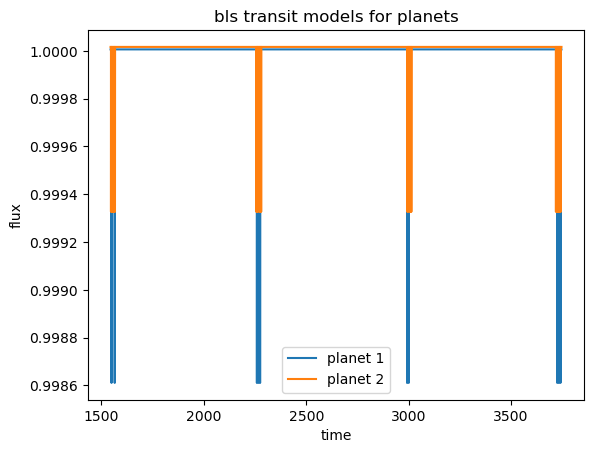

In [32]:
plt.plot(planet_1_model.time.value, planet_1_model.flux.value, label='planet 1')
plt.plot(planet_2_model.time.value, planet_2_model.flux.value, label='planet 2')
# plt.plot(planet_3_model.time.value, planet_3_model.flux.value, label='planet 3')
# plt.plot(planet_4_model.time.value, planet_4_model.flux.value, label='planet 4')
# plt.plot(planet_5_model.time.value, planet_5_model.flux.value, label='planet 5?')
# plt.plot(planet_6_model.time.value, planet_6_model.flux.value, label='planet 6?')

# plt.xlim(1335,1345)
# plt.xlim(1330,1350)
# plt.xlim(2100,2200)
# plt.xlim(1377,1380)
plt.title('bls transit models for planets')
plt.xlabel('time')
plt.ylabel('flux')
plt.legend()
plt.show()

# Fit Transit Times

In [33]:
from scipy.optimize import minimize
from scipy.optimize import root_scalar
from scipy.optimize import least_squares
from scipy.optimize import curve_fit

## Definitions

In [34]:
def omc(obs_time, t_num, p, tc):
    calc_time = tc + (t_num* p)
    omc = obs_time - calc_time
    return omc#*24 #days to hours

### Find the intersection points
def intersection_func(t,tc1,chi_sq, err_threshold): 
    return np.interp(t, tc1, chi_sq) - err_threshold

In [35]:

def plot_chi_sq(time, flux, flux_err, tc, tc_guess, per, rp, b, T14, u1, u2):
    '''
    args:
        time: array of times from lightcurve
        flux: array of fluxes from lightcurve
        flux_err: array of flux errors from lightcurve
        tc: range of values around the guess time
        tc_guess: guess transit time
        per: period of planet
        rp: radius ratio (planet/star)
        b: impact parameter
        T14: transit duration
        u1, u2: limb darkening coefficients 
    '''
    ### plot X^2 vs tc for each guess
    for j in range(len(tc)):
        tc1 = tc[j]
        chi_sq = np.zeros(len(tc1))
        chi_sq_lc = np.zeros(len(tc1))
        for i in range(len(tc1)):
            t0_1 = 	tc1[i]
            theta_initial = [t0_1, per, rp, b, T14, u1, u2]
            
            ### initialize params
            params = batman.TransitParams()
            # params.t0, params.per, params.rp,params.b, params.T14, q1, q2 = theta_initial
            # params.u = [2*np.sqrt(q1)*q2, np.sqrt(q1)*(1-2*q2)]  # Limb darkening coefficients
            params.t0, params.per, params.rp,params.b, params.T14, u1, u2 = theta_initial
            params.u = [u1, u2] 
            params.limb_dark = 'quadratic'
            
            ### mask data - extract relevant photometry
            start = tc_guess[j] - ttv_hour
            end = tc_guess[j] + ttv_hour
            mask = (time > (start)) & (time < (end))
            
            transit_model = batman.TransitModel(params, time[mask])
                
            # Generate model light curve
            model_flux = transit_model.light_curve(params)
            
            # Calculate chi-squared value
            sigma2 = flux_err[mask] 
            chi_squared = np.sum(((flux[mask] - model_flux) / sigma2)**2)
            chi_sq[i] = (chi_squared)
    
        ### masked
        min_chi_time = tc1[np.argmin(chi_sq)]
        min_chi = chi_sq.min()
    
        tc_chi[j] = min_chi_time
        # idx = transit_num[j]
        ttv[j] = min_chi_time - tc_guess[j]
    
        chi_mask = (chi_sq <= min_chi + 3)
        fit_mask = (chi_sq <= min_chi + 1)
    
        ### fit parabola to the chisq
        p_chi_sq = np.polyfit(tc1[fit_mask], chi_sq[fit_mask], 2)  
    
        ### Extract the coefficients   y = ax^2 + bx + c
        a_chi_sq, b_chi_sq, c_chi_sq = p_chi_sq
        
        ### Find the minimum of the parabola xmin = -b/2a from taking derivative=0
        tc_best_fit = -b_chi_sq / (2 * a_chi_sq)
        
        ### Calculate the minimum chi-squared value
        chi_sq_min = a_chi_sq * tc_best_fit**2 + b_chi_sq * tc_best_fit + c_chi_sq
        tc_chi_parabola[j] = tc_best_fit
    
        ### Calculate the parabola best fit 
        p_1 = a_chi_sq*tc1**2 + b_chi_sq*tc1 + c_chi_sq
    
        ### calculate ttv from parabola fit 
        ttv_p[j] = tc_best_fit - tc_guess[j]
    
        ### delta chisq = 1 gives errors
        err_threshold = min_chi + 1 # using chisq discrete minimum
        err_threshold_p = chi_sq_min + 1 # using minimum of parabola
      
        # # Find the intersection using root_scalar
        # intersections = []
        # for k in range(len(tc1) - 1):
        #     if (chi_sq[k] - err_threshold) * (chi_sq[k + 1] - err_threshold) < 0:
        #         sol = root_scalar(intersection_func, bracket=[tc1[k], tc1[k + 1]], args=(tc1, chi_sq, err_threshold))
        #         if sol.converged:
        #             intersections.append((sol.root - min_chi_time))
        # errors.append(intersections)
    
        # intersections_p = []
        # for k in range(len(tc1) - 1):
        #     if (p_1[k] - err_threshold_p) * (p_1[k + 1] - err_threshold_p) < 0:
        #         sol = root_scalar(intersection_func, bracket=[tc1[k], tc1[k + 1]], args=(tc1, chi_sq, err_threshold))
        #         if sol.converged:
        #             intersections_p.append((sol.root - tc_best_fit))
        # errors_p.append(intersections_p)
    
        # plt.plot(tc1[chi_mask], chi_sq[chi_mask],label='chisq')
        # plt.plot(tc1[chi_mask], p_1[chi_mask],label='chisq parabola', color='orange')
        # plt.axvline(x=tc_guess[j], color='r', linestyle='--', label='Bls Guess')
        # plt.axvline(x=min_chi_time, linestyle='--', label='Chisq min')
        # plt.axvline(x=tc1[np.argmin(p_1)], color='orange', linestyle='--', label='Chisq min parabola')
    
        # # for inter in intersections:
        # #     plt.axvline(x=inter, color='blue', linestyle='--')
        # plt.axhline(y=err_threshold, color='green', linestyle='--', label='Error Threshold')
        # plt.title(f'Transit {j+1}: Planet b')
        # plt.xlabel('tc')
        # plt.ylabel('X^2')
        # plt.legend()
        # plt.show()

    return tc_chi, ttv

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FuncFormatter
import batman

def plot_transits(transit_times, per, rp, b, T14, u1, u2):
    cols = 3
    rows = int(np.ceil(len(transit_times) / cols))
    
    fig = plt.figure(figsize=(14, rows * 2.8))
    outer = gridspec.GridSpec(rows, cols, figure=fig, wspace=0.3, hspace=0.5)
    
    for i, t0 in enumerate(transit_times):
        row = i // cols
        col = i % cols
        inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[row, col],
                                                 height_ratios=[3, 1], hspace=0.0)  # Panels touch
    
        t_min = t0 - buffer
        t_max = t0 + buffer
        mask = (time >= t_min) & (time <= t_max)
        time_rel = time[mask] - t0  # Time relative to Tc
    
        # Transit model setup
        theta_initial = [t0, per, rp, b, T14, u1, u2]
        params = batman.TransitParams()
        params.t0, params.per, params.rp, params.b, params.T14, u1, u2 = theta_initial
        params.u = [u1, u2]
        params.limb_dark = 'quadratic'
    
        m = batman.TransitModel(params, time[mask])
        model_flux = m.light_curve(params)
        residuals = flux[mask] - model_flux
    
        # Top panel: model + data
        ax1 = fig.add_subplot(inner[0])
        ax1.scatter(time_rel, flux[mask], s=5, label='Data')
        ax1.plot(time_rel, model_flux, color='red', label='Model')
        ax1.axvline(0, color='green', linestyle='--', label='Tc')
        ax1.set_xlim(-buffer, buffer)
        ax1.set_title(f'Tc = {round(t0, 3)} (BJD-{TESS_offset})')
        ax1.grid(True)
        ax1.tick_params(labelbottom=False)
    
        # Bottom panel: residuals
        ax2 = fig.add_subplot(inner[1], sharex=ax1)
        ax2.scatter(time_rel, residuals, s=5)
        ax2.axhline(0, color='red', linestyle='--', linewidth=1)
        ax2.set_xlim(-buffer, buffer)
        ax2.set_xlabel("Time from Tc [days]")
        ax2.grid(True)
    
        # Y-axis labels for first column only
        if col == 0:
            ax1.set_ylabel("Flux")
            ax2.set_ylabel("Residuals")
        else:
            ax1.set_ylabel("")
            ax1.tick_params(labelleft=False)
            ax2.set_ylabel("")
            ax2.tick_params(labelleft=False)
    
        # Custom ticks
        ticks = np.round(np.linspace(-buffer, buffer, 4), 2)
        ax2.set_xticks(ticks)
    
    plt.show()


In [38]:
### stellar params
# r1 and r2 in Cointepas et al 2024
u1 = 0.45
u2 = 0.04
print(u1)
print(u2)

0.45
0.04


## Planet 1

In [39]:
### Planet params (from exoplanet archive Cointepas et al 2024)
# planet b
per_1=  7.1027268
rp_1= 0.0345
b_1= 0.17
T14_1= 1.2 * 0.0416667  # convert to days from hours (no duration info in paper)


In [40]:
tc_guess_1 = transit_times_1
### get tc ranges for fit
tc_1 = []
for i in range(len(tc_guess_1)):
    start = tc_guess_1[i] - ttv_hour
    end = tc_guess_1[i] + ttv_hour
    t = np.linspace(start,end, 1000)
    tc_1.append(t)

In [41]:
### initialize arrays
tc_chi = np.zeros(len(tc_1))
tc_chi_parabola = np.zeros(len(tc_1))
ttv = np.zeros(len(tc_1))
ttv_p = np.zeros(len(tc_1))
errors = []
errors_p = []

In [42]:
tc_chi_1, ttv_1 = plot_chi_sq(time, flux, flux_err, tc_1, tc_guess_1, per_1, rp_1, b_1, T14_1, u1, u2)

In [43]:
print(tc_chi_1)

[1549.59379524 1565.19103264 2259.05773248 2266.8809777  2274.6873262
 2991.97801386 2999.76753501 3724.85408878 3732.66526835 3740.45802944]


In [44]:
# Transit windows
buffer = 1.5 * T14_1
transit_times_1 = tc_chi_1

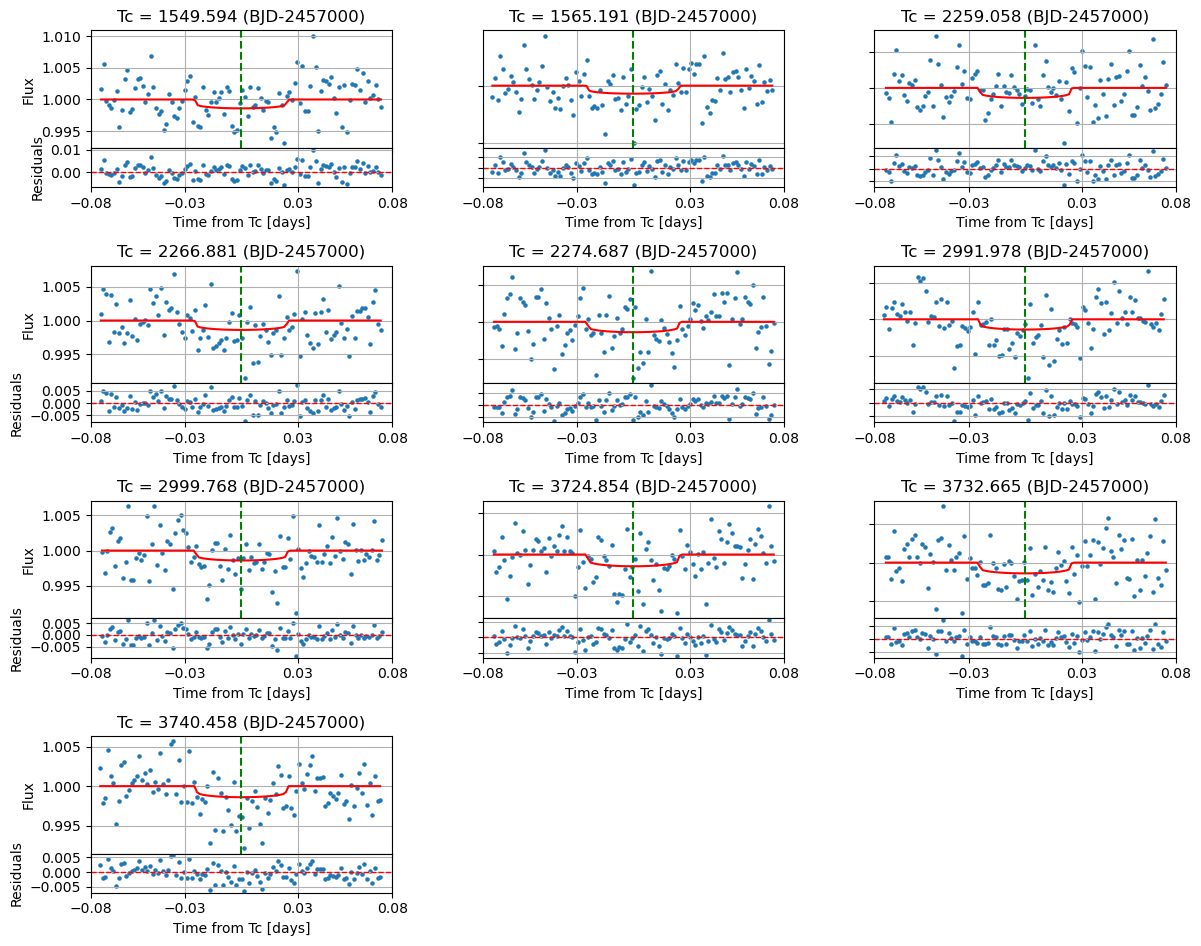

In [45]:
plot_transits(transit_times_1, per_1, rp_1, b_1, T14_1, u1, u2)

## Planet 2

In [46]:
### Planet params (from barros et al 2022)
# planet b
per_2=  4.6955507
rp_2=  0.0404
b_2= 0.23
T14_2= 1.2 * 0.0416667  # convert to days from hours (from Gunther et al 2019)


In [47]:
tc_guess_2 = transit_times_2
### get tc ranges for fit
tc_2 = []
for i in range(len(tc_guess_2)):
    start = tc_guess_2[i] - ttv_hour
    end = tc_guess_2[i] + ttv_hour
    t = np.linspace(start,end, 1000)
    tc_2.append(t)

In [48]:
### initialize arrays
tc_chi = np.zeros(len(tc_2))
tc_chi_parabola = np.zeros(len(tc_2))
ttv = np.zeros(len(tc_2))
ttv_p = np.zeros(len(tc_2))
errors = []
errors_p = []

In [49]:
tc_chi_2, ttv_2 = plot_chi_sq(time, flux, flux_err, tc_2, tc_guess_2, per_2, rp_2, b_2, T14_2, u1, u2)

In [50]:
print(tc_chi_2)

[1546.99195505 1550.88807217 1554.77675789 1558.70100523 1562.58036556
 1566.48104927 2256.4894481  2260.41906821 2264.27525312 2272.07489789
 2275.92300208 2279.8821814  2993.29196323 2997.17427373 3004.97660988
 3008.94637402 3012.77614016 3718.26614365 3722.17188609 3726.23009274
 3730.08452436 3733.91796563 3737.87065435 3741.78428413]


In [51]:
# Transit windows
buffer = 1.5 * T14_2
transit_times_2 = tc_chi_2

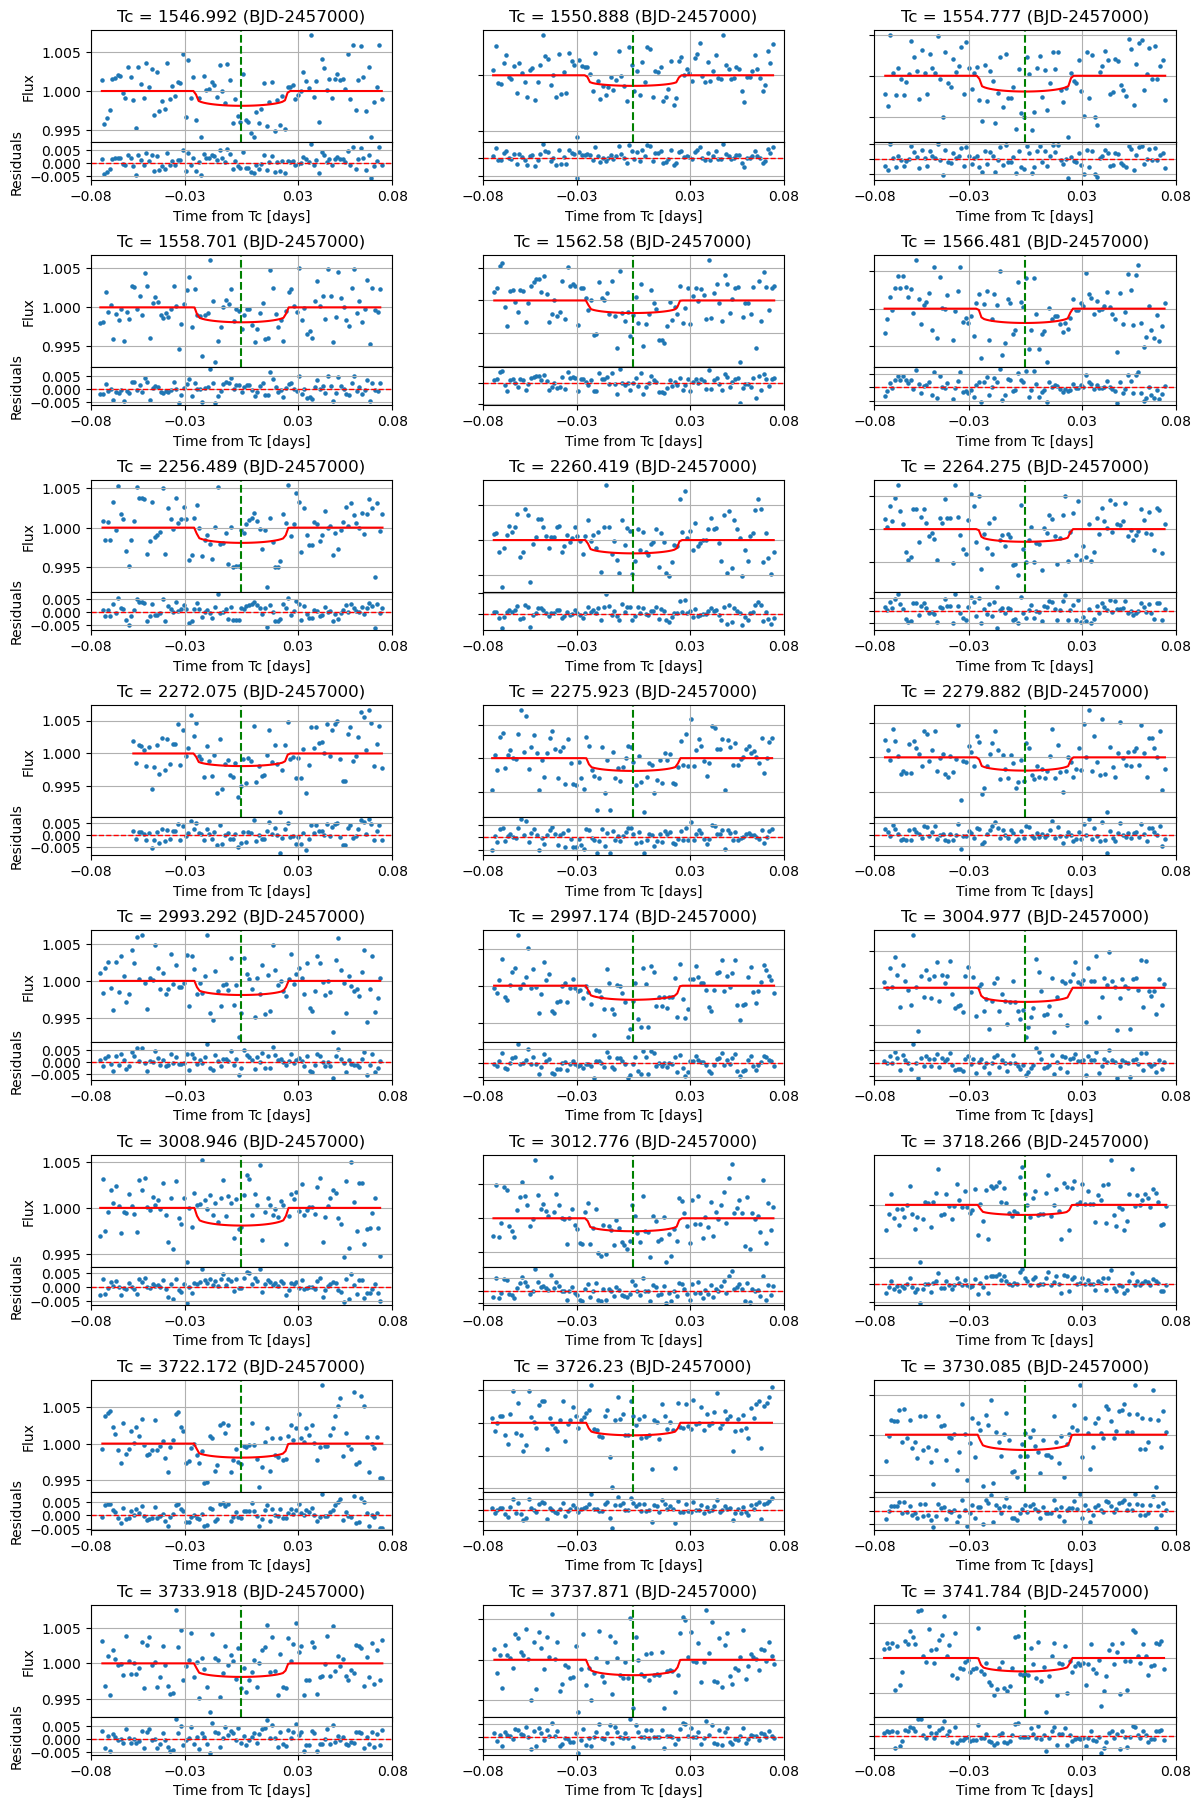

In [52]:
plot_transits(transit_times_2, per_2, rp_2, b_2, T14_2, u1, u2)

# O-C

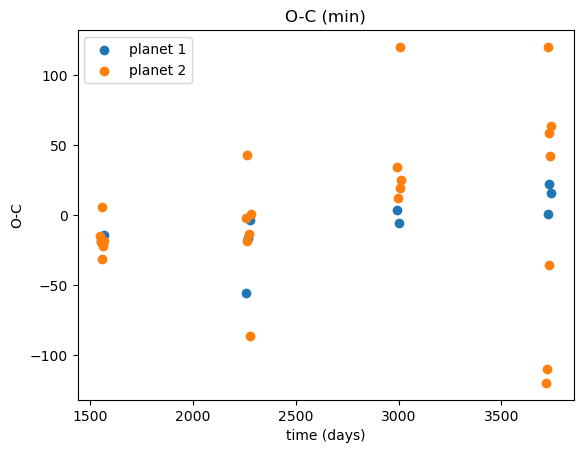

In [53]:
# TTV
plt.scatter(tc_chi_1, ttv_1*(24*60), label='planet 1')
plt.scatter(tc_chi_2, ttv_2*(24*60), label='planet 2')
plt.title('O-C (min)')
plt.xlabel('time (days)')
plt.ylabel('O-C')
plt.legend()
plt.show()

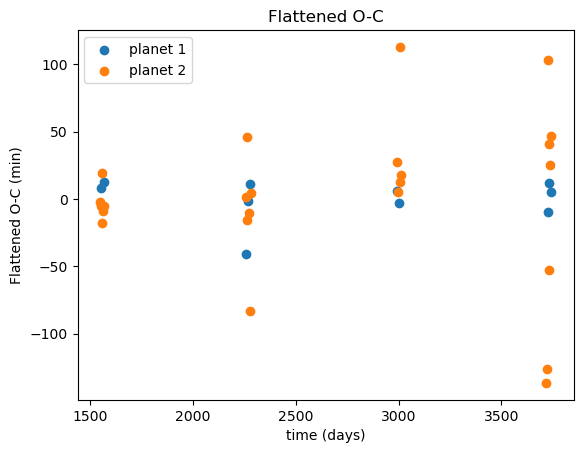

In [54]:
# Fit a linear function to the TTV data
coeffs_1 = np.polyfit(tc_chi_1, ttv_1*(24*60), 1)
linear_fit_1 = np.polyval(coeffs_1, tc_chi_1)

coeffs_2 = np.polyfit(tc_chi_2, ttv_2*(24*60), 1)
linear_fit_2 = np.polyval(coeffs_2, tc_chi_2)

# Subtract the linear fit from the TTV data
ttv_1_detrended = ttv_1*(24*60) - linear_fit_1
ttv_2_detrended = ttv_2*(24*60) - linear_fit_2

# Plot the detrended data
plt.scatter(tc_chi_1, ttv_1_detrended, label='planet 1')
plt.scatter(tc_chi_2, ttv_2_detrended, label='planet 2')
plt.title('Flattened O-C')
plt.xlabel('time (days)')
plt.ylabel('Flattened O-C (min)')
plt.legend()
plt.show()

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Convert to minutes
ttv_1_minutes = ttv_1 * 24 * 60

# Sine + linear model
def model(t, a, b, A, P, phi):
    return a * t + b + A * np.sin(2 * np.pi * t / P + phi)

# Initial guesses
# Guess P (period) from visual estimate (e.g., ~100 days), adjust as needed
p0 = [0, np.mean(ttv_1_minutes), 1, 100, 0]  

# Fit the model
params, _ = curve_fit(model, tc_chi_1, ttv_1_minutes, p0=p0, maxfev=10000)

# Extract fit values
a, b, A, P, phi = params

# Generate fitted curve
t_fit = np.linspace(min(tc_chi_1), max(tc_chi_1), 1000)
ttv_fit = model(t_fit, a, b, A, P, phi)

# # Plot data and fit
# plt.scatter(tc_chi_1, ttv_1_minutes, label='planet 1 data')
# plt.plot(t_fit, ttv_fit, color='red', label='fit: linear + sinusoid', linewidth=2)
# plt.title('TTV Fit: Linear + Sinusoid')
# plt.xlabel('time (days)')
# plt.ylabel('O-C (min)')
# plt.legend()
# plt.show()

# # Print parameters
# print(f"""
# Fit Parameters:
#   Slope (a)      = {a:.5f} min/day
#   Intercept (b)  = {b:.5f} min
#   Amplitude (A)  = {A:.5f} min
#   Period (P)     = {P:.2f} days
#   Phase (phi)    = {phi:.2f} rad
# """)


In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Convert to minutes
ttv_2_minutes = ttv_2 * 24 * 60

# Sine + linear model
def model(t, a, b, A, P, phi):
    return a * t + b + A * np.sin(2 * np.pi * t / P + phi)

# Initial guesses
# Guess P (period) from visual estimate (e.g., ~100 days), adjust as needed
p0 = [0, np.mean(ttv_2_minutes), 1, 100, 0]  

# Fit the model
params, _ = curve_fit(model, tc_chi_2, ttv_2_minutes, p0=p0, maxfev=10000)

# Extract fit values
a, b, A, P, phi = params

# Generate fitted curve
t_fit_2 = np.linspace(min(tc_chi_2), max(tc_chi_2), 1000)
ttv_fit_2 = model(t_fit, a, b, A, P, phi)

# Plot data and fit
# plt.scatter(tc_chi_2, ttv_2_minutes, label='planet 1 data')
# plt.plot(t_fit_2, ttv_fit_2, color='red', label='fit: linear + sinusoid', linewidth=2)
# plt.title('TTV Fit: Linear + Sinusoid')
# plt.xlabel('time (days)')
# plt.ylabel('O-C (min)')
# plt.legend()
# plt.show()

# Print parameters
# print(f"""
# Fit Parameters:
#   Slope (a)      = {a:.5f} min/day
#   Intercept (b)  = {b:.5f} min
#   Amplitude (A)  = {A:.5f} min
#   Period (P)     = {P:.2f} days
#   Phase (phi)    = {phi:.2f} rad
# """)


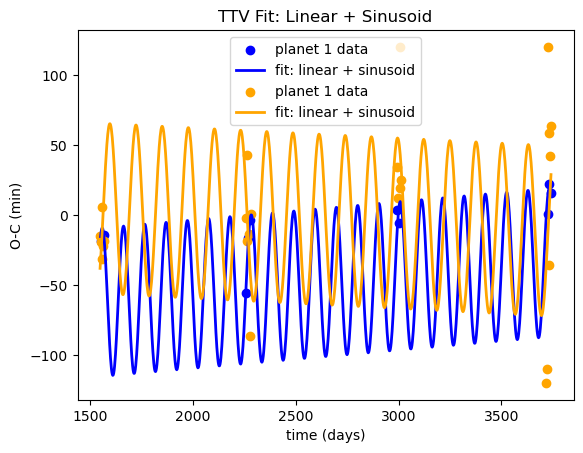

In [57]:
# Plot data and fit
plt.scatter(tc_chi_1, ttv_1_minutes, c='blue',label='planet 1 data')
plt.plot(t_fit, ttv_fit, color='blue', label='fit: linear + sinusoid', linewidth=2)

# Plot data and fit
plt.scatter(tc_chi_2, ttv_2_minutes,c='orange', label='planet 1 data')
plt.plot(t_fit_2, ttv_fit_2, color='orange', label='fit: linear + sinusoid', linewidth=2)
plt.title('TTV Fit: Linear + Sinusoid')
plt.xlabel('time (days)')
plt.ylabel('O-C (min)')
plt.legend()
plt.show()